In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('..')
sys.path.append('../../')
sys.path.append('../data_processing/')
sys.path.append('../model/')
sys.path.append('../model/utils/')
sys.path.append('../model/EGNN_backbone')

In [3]:
import numpy as np
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pylab as plt

In [4]:
%matplotlib inline

In [5]:
from data_processing.paired_data import PharmacophoreDataset, CombinedGraphDataset, CombinedSparseGraphDataset
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated

In [6]:
from model.pp_bridge import PPBridge
from model.pp_bridge_sampler import PPBridgeSampler
from model.utils.utils_diffusion import center2zero_combined_graph, center2zero_with_mask, center2zero

In [7]:
from script_utils import load_data
from evaluation.utils import build_pdb_dict

In [9]:
# init with fixed points
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104' # only basic
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216' # support aromatic

# init with standard gaussian noise
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248' # only basic
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433' # support aromatic

# CE loss
# model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042' # only basic
model_root = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031' # support aromatic

basic_mode = False

In [10]:
config_file = os.path.join(model_root, 'vp_bridge_egnn.yml')
# config_file = '../../src/config/ve_bridge.yml'
config = OmegaConf.load(config_file)
# config.data.aromatic = True
config

{'model': {'denoiser': {'bridge_type': 'vp', 'beta_d': 2, 'beta_min': 0.1, 'sigma_data': 0.5, 'sigma_max': 1, 'sigma_min': 0.0001, 'schedule_sampler': 'real-uniform', 'use_ema': True, 'ema_decay': 0.999, 'weight_decay': 1e-12, 'weight_schedule': 'uniform', 'loss_x_weight': 10.0}, 'backbone': {'type': 'EGNN', 'feature_size': 12, 'num_layers': 10, 'hidden_size': 128, 'time_cond': True, 'xT_type': 'pp', 'xT_mode': 'concat_graph'}}, 'training': {'batch_size': 200, 'log_interval': 100, 'save_interval': 1000, 'test_interval': 1000, 'total_training_steps': 10000000, 'learning_rate': 0.01, 'lr_anneal_steps': 0, 'max_epochs': 100, 'use_lr_scheduler': True, 'lr_scheduler_config': {'target': 'model.utils.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [10000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}}, 'sampling': {'batch_size': 2000}, 'data': {'root': '../data/cleaned_crossdocked_data', 'max_node_num': 86, 'coord_dim': 3, 'module': 

In [11]:
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104/epoch=94-val_loss=2.98.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216/epoch=98-val_loss=3.15.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433/epoch=85-val_loss=4.38.ckpt'
# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248/epoch=82-val_loss=4.18.ckpt'

# ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042/epoch=89-val_loss=16.68.ckpt'
ckpt_path = '../../src/lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031/epoch=72-val_loss=19.98.ckpt'
# ckpt = torch.load(ckpt_path)
# ckpt

In [12]:
device = 'cuda:3'

In [13]:
sampler = PPBridgeSampler(config, ckpt_path, device)

Using lr scheduler
Using real uniform sampler
Using lr scheduler
Using real uniform sampler


In [14]:
root = '/home/conghao001/pharmacophore2drug/PP2Drug/data/cleaned_crossdocked_data'
split = 'train'
batch_size = 10
num_workers = 0

In [15]:
# dataset = CombinedGraphDataset(root, split)
# dataset = CombinedSparseGraphDataset(root, split)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset, _ = load_data(config.data.module, root, split=split, batch_size=batch_size, aromatic=config.data.aromatic)

In [66]:
dataloader = DataLoader(dataset[2700:3000], batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [67]:
len(dataset)

181471

In [68]:
pdb_dict, pdb_rev_dict = build_pdb_dict(root)

In [69]:
one = next(iter(dataloader))
one = one.to(device)
one

DataBatch(x=[332, 12], pos=[332, 3], target_x=[332, 12], target_pos=[332, 3], Gt_mask=[332], ligand_name=[10], batch=[332], ptr=[11])

In [70]:
# for batch in dataloader:
#     if batch.ligand_name[0] == '4ls1_A_rec_5h73_7l7_lig_tt_min_0':
#         one = batch
# one = one.to(device)

In [71]:
one.ligand_name

['2al2_A_rec_1ebg_pah_lig_tt_min_0',
 '2xgz_A_rec_1l8p_pah_lig_tt_docked_1',
 '3dye_A_rec_3dye_lnr_lig_tt_min_0',
 '2f12_A_rec_2f10_bcz_lig_tt_min_0',
 '3tt0_A_rec_3gql_gql_lig_tt_docked_0',
 '1fgi_A_rec_1fgi_su1_lig_tt_min_0',
 '2fgi_A_rec_3rhx_3rh_lig_tt_min_0',
 '7enl_A_rec_1p48_pep_lig_tt_min_0',
 '2al1_A_rec_2one_2pg_lig_it1_it2_tt_docked_13',
 '3c4f_B_rec_1fgi_su1_lig_tt_min_0']

In [72]:
# tmp_mask = one.Gt_mask.view(batch_size, -1)
# one.target_x[0][tmp_mask[0]].size()

In [73]:
# for node_feat in one.target_x[one.Gt_mask]:
#     print(node_feat)

In [74]:
num_nodes = one.x.size(0)
node_mask = torch.ones([1, num_nodes], device=one.x.device, dtype=torch.bool)

In [75]:
xT, hT, Gt_mask, batch_info = sampler.preprocess(one.target_pos, one.target_x, node_mask=node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, device=device)

In [76]:
xT.size()

torch.Size([332, 3])

In [77]:
hT

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:3')

In [78]:
Gt_mask.size()

torch.Size([332])

## Important
***sigma min and max values***
differ for ve/vp bridges!!!

In [79]:
steps = 500
# x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, churn_step_ratio=0.33, device=device)
x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, sigma_min=0.001, sigma_max=1, churn_step_ratio=0.33, device=device)

nfe: 1499


In [80]:
print(x.size(), x[Gt_mask].size())

torch.Size([332, 3]) torch.Size([166, 3])


In [81]:
one.batch.size()

torch.Size([332])

In [82]:
num_graphs = max(one.batch).item() + 1
num_graphs

10

In [83]:
i = 1
index_i = one.batch==i
index_i.sum()

tensor(18, device='cuda:3')

In [84]:
# x_i = x[Gt_mask][index_i]
x_i = x[index_i][Gt_mask[index_i]]
x_i.size()

torch.Size([9, 3])

In [85]:
Gt_mask.device

device(type='cuda', index=3)

In [86]:
x_traj_i = [xt[index_i.cpu()][Gt_mask[index_i].cpu()] for xt in x_traj]
x_traj_i

[tensor([[ 0.0372, -0.0157, -0.0801],
         [ 0.0405, -0.0072, -0.0979],
         [ 0.3765, -2.1560, -1.0530],
         [ 0.0377, -0.0160, -0.0796],
         [ 1.9773, -0.5685, -0.6485],
         [-0.3675,  1.9450,  1.7326],
         [-2.1471,  0.8157,  0.3896],
         [ 0.0188, -0.0048, -0.0800],
         [ 0.0265,  0.0074, -0.0833]], device='cuda:3'),
 tensor([[ 0.0226, -0.1098, -0.1027],
         [ 0.1078, -0.0103, -0.0305],
         [ 0.4082, -2.1136, -1.1129],
         [ 0.0761, -0.0841,  0.0764],
         [ 1.9908, -0.6789, -0.6639],
         [-0.3300,  1.9094,  1.6186],
         [-2.0946,  0.8661,  0.4135],
         [ 0.0541,  0.0089, -0.1270],
         [ 0.0112, -0.0748, -0.0824]]),
 tensor([[ 0.0095, -0.1855, -0.1215],
         [ 0.1614, -0.0125,  0.0234],
         [ 0.4340, -2.0765, -1.1601],
         [ 0.1064, -0.1392,  0.2018],
         [ 2.0012, -0.7668, -0.6763],
         [-0.2992,  1.8778,  1.5243],
         [-2.0491,  0.9053,  0.4326],
         [ 0.0820,  0.0202, -

In [87]:
len(x_traj_i)

1001

In [88]:
len(x_traj)

1001

In [89]:
x_traj_i[0].size()

torch.Size([9, 3])

In [90]:
x_traj[0].size()

torch.Size([332, 3])

In [91]:
x_i

tensor([[-1.3509e+00, -1.2022e-01,  2.5980e-01],
        [ 1.6716e-03,  5.0645e-01,  4.3484e-01],
        [ 3.2313e-01, -1.5066e+00, -5.1584e-01],
        [ 6.7548e-01,  4.9180e-01,  1.6286e+00],
        [ 1.1973e+00, -4.9298e-01, -5.3498e-01],
        [ 3.0370e-01,  2.0764e+00,  3.0090e+00],
        [-5.7566e-01,  1.4081e+00,  2.2606e+00],
        [ 5.2248e-01,  1.8780e+00, -1.3085e-01],
        [-1.1217e+00, -1.6813e+00, -4.7827e-01]], device='cuda:3')

In [92]:
x_i_arr = x_i.cpu().numpy()

x_i_arr[:, 0]

array([-1.3508886 ,  0.00167156,  0.32312748,  0.6754804 ,  1.197282  ,
        0.30370384, -0.5756643 ,  0.5224836 , -1.121674  ], dtype=float32)

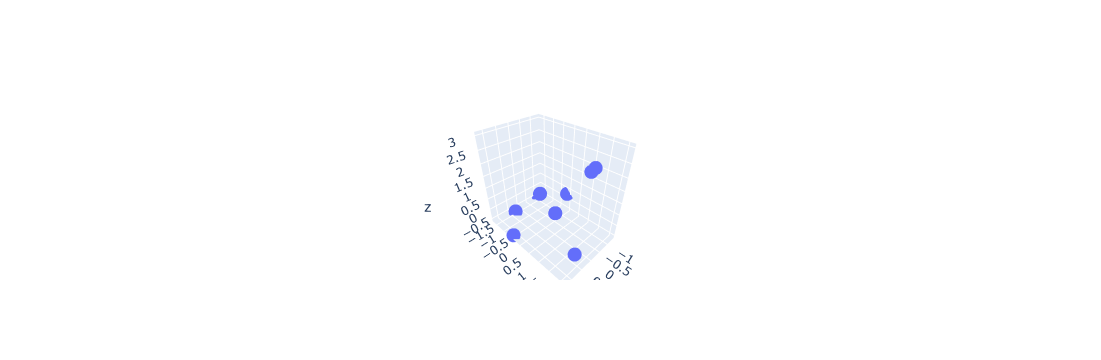

In [93]:
fig = go.Figure(data=[go.Scatter3d(x=x_i_arr[:, 0], y=x_i_arr[:, 1], z=x_i_arr[:, 2],
                                   mode='markers')])
fig.show()

In [94]:
xt_sampled = [x_traj_i[i] for i in range(len(x_traj_i)) if i%80==0]
len(xt_sampled)

13

In [95]:
nc = 3
nr = len(xt_sampled)//nc + 1
fig = make_subplots(rows=nr, cols=nc, 
                   specs = [[{"type": "scatter3d"} for i in range(nc)] for i in range(nr)]
                   )

for i in range(len(xt_sampled)):
    arr = xt_sampled[i].cpu().numpy()
    fig.add_trace(
        go.Scatter3d(x=arr[:, 0], y=arr[:, 1], z=arr[:, 2], mode='markers'),
        row=i//nc + 1, col=i%nc + 1
    )

fig.update_layout(height=nr*350, showlegend=False)
fig.show()

In [96]:
# one.original_pos
original_pos_i = one.pos[index_i][Gt_mask[index_i]]
original_pos_0center_i = center2zero(original_pos_i)
original_pos_0center_i.size()

torch.Size([9, 3])

In [97]:
original_pos_0center_i_arr = original_pos_0center_i.cpu().numpy()

In [98]:
fig = make_subplots(rows=1, cols=2, 
                   specs = [[{"type": "scatter3d"} for i in range(2)]]
                   )


fig.add_trace(
    go.Scatter3d(x=x_i_arr[:, 0], y=x_i_arr[:, 1], z=x_i_arr[:, 2], mode='markers'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter3d(x=original_pos_0center_i_arr[:, 0], y=original_pos_0center_i_arr[:, 1], z=original_pos_0center_i_arr[:, 2], mode='markers'),
    row=1, col=2
)

# fig.update_layout(height=500, showlegend=False)
fig.show()

In [99]:
one.pos.size()

torch.Size([332, 3])

In [100]:
h_i = h[index_i][Gt_mask[index_i]]
h_i.size()

torch.Size([9, 12])

In [101]:
h_i

tensor([[ 0.8970, -0.6833,  0.0628, -0.0887, -0.0642, -0.2572, -0.0815, -0.0570,
          0.0380,  0.0943, -0.1603,  0.1046],
        [ 0.3340,  0.5966, -1.1801,  0.3696,  0.2789,  0.2764, -0.5426, -0.3573,
         -0.5058, -1.1644, -0.3130,  0.1133],
        [-0.7765,  0.9210, -0.2109,  0.1875, -0.8301, -0.0290, -0.8348,  0.7792,
          0.2647, -0.5114,  0.1019,  0.4865],
        [ 0.5760,  1.3795,  0.2645,  0.1103, -0.0171,  0.2642, -0.3803,  0.3389,
          0.7454,  0.0608,  0.1252,  0.0313],
        [-0.7125, -0.3127,  0.0943, -2.0975,  1.2651, -0.2305,  0.3275, -1.4176,
         -0.0280,  1.1494, -0.2020,  0.3446],
        [-0.0294, -0.2966,  0.2150, -0.1166,  0.3831,  0.1357,  0.5685,  0.2431,
          0.2932, -0.6004, -0.8301,  0.0659],
        [ 1.3139, -0.5723,  0.0556, -0.0578,  0.7486, -0.4198,  0.1449,  0.0091,
          0.5281, -0.2242,  0.0828, -0.2378],
        [-0.9649, -0.0334,  0.0981,  0.4465,  0.7355, -0.2322, -0.6510,  0.9899,
          0.2898, -0.3493,  0.

In [102]:
h_traj_i = [xt[index_i.cpu()][Gt_mask[index_i].cpu()] for xt in x_traj]

In [103]:
# torch.argmax(one.x[i], dim=-1)
torch.argmax(one.x, dim=-1)

tensor([0, 0, 2, 4, 4, 4, 4, 4, 7, 0, 0, 5, 5, 6, 6, 5, 5, 0, 0, 0, 2, 4, 4, 4,
        4, 4, 7, 0, 0, 5, 0, 6, 6, 5, 0, 0, 4, 1, 1, 1, 4, 1, 1, 1, 0, 4, 0, 2,
        5, 2, 2, 2, 5, 2, 2, 2, 0, 5, 0, 5, 0, 0, 0, 4, 0, 0, 0, 4, 4, 2, 0, 2,
        2, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 4, 4, 3, 3, 3, 3,
        0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 4, 2, 3, 1, 1, 1,
        6, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 0, 4, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2,
        2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 6, 3, 1, 1, 1, 1, 0, 2, 0,
        4, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 4, 4, 2, 2, 2, 2, 2, 0, 5, 0, 6, 0,
        2, 2, 2, 2, 2, 2, 1, 0, 0, 4, 4, 4, 1, 1, 3, 1, 2, 3, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 5, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 4, 7, 4, 4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 1, 4,
        4, 4, 0, 0, 4, 4, 0, 4, 4, 7, 4, 4, 4, 0, 4, 4, 4, 0, 5, 4, 4, 4, 4, 4,
        3, 1, 1, 1, 1, 0, 2, 0, 4, 0, 1,

In [104]:
# h = F.softmax(h, dim=-1)
h_class = torch.argmax(h_i, dim=-1)
h_class

tensor([0, 1, 1, 1, 4, 6, 0, 7, 3], device='cuda:3')

In [105]:
h_onehot = torch.nn.functional.one_hot(h_class, num_classes=13)
h_onehot

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:3')

In [106]:
atom_index = h_class.detach().cpu()
if h_onehot.size(-1) == 8:
    index_to_atom_type = MAP_ATOMIC_NUMBER_TO_INDEX
    atom_type = get_atomic_number_from_index(atom_index, index_to_atom_type=index_to_atom_type_aromatic)
else:
    atom_type = get_atomic_number_from_index(atom_index)
atom_type

[6, 6, 6, 6, 8, 9, 6, 15, 7]

In [107]:
if basic_mode:
    atom_aromatic = None
else:
    atom_aromatic = is_aromatic_from_index(atom_index)
atom_aromatic

[False, True, True, True, False, False, False, False, True]

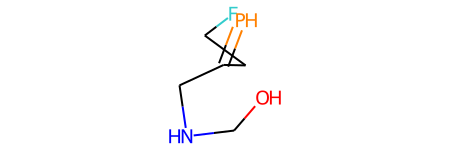

In [108]:
pos = x_i.detach().cpu().tolist()
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic, basic_mode)
mol

[15:16:44] UFFTYPER: Warning: hybridization set to SP3 for atom 7
[15:16:44] Molecule does not have explicit Hs. Consider calling AddHs()


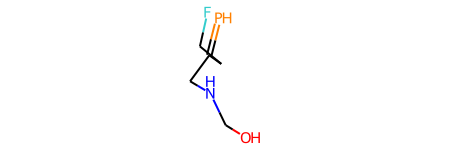

In [109]:
# mol = Chem.AddHs(mol, addCoord=True)
UFFOptimizeMolecule(mol)
mol

In [110]:
# this is for aromatic!!! not basic mode!!!

mols = []
for i in range(num_graphs):
    index_i = one.batch==i
    x_i = x[index_i][Gt_mask[index_i]]
    h_i = h[index_i][Gt_mask[index_i]]
    h_class = torch.argmax(h_i, dim=-1)
    atom_index = h_class.detach().cpu()
    atom_type = get_atomic_number_from_index(atom_index)
    atom_aromatic = is_aromatic_from_index(atom_index)
    pos = x_i.detach().cpu().tolist()
    try:
        mol = reconstruct_from_generated(pos, atom_type, atom_aromatic, basic_mode)
        mols.append(mol)
    except:
        continue

[15:16:47] Explicit valence for atom # 4 Cl, 3, is greater than permitted
[15:16:47] Explicit valence for atom # 16 Cl, 3, is greater than permitted


In [111]:
len(mols)

8

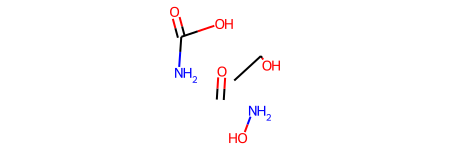

In [125]:
example = mols[6]
example

[15:18:12] Molecule does not have explicit Hs. Consider calling AddHs()


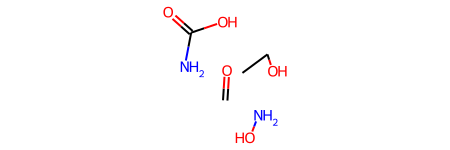

In [126]:
# example = Chem.AddHs(example, addCoord=True)
UFFOptimizeMolecule(example)
example

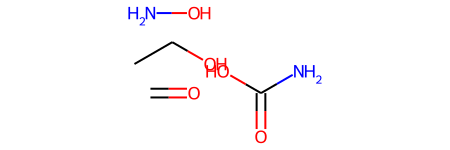

In [127]:
m = Chem.MolFromSmiles(Chem.MolToSmiles(example))
m

In [353]:
# with Chem.SDWriter('generated_example.sdf') as w:
#   w.write(m)